<a href="https://colab.research.google.com/github/Mountain-C/Class-Projects/blob/master/Codes/Numerical_Analysis/Solving_a_discrete_boundary_value_problem_by_approximating_Laplace_operator_using_5_point_finite_difference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
from scipy.sparse import coo_matrix


n = 100
c = 1

def f(u):
    return u**3

def f_prime(u):
    return 3 * u**2
  
  
def fun(u, n, f, f_prime, c, **kwargs):
    v = np.zeros((n + 2, n + 2))
    u = u.reshape((n, n))
    v[1:-1, 1:-1] = u
    y = v[:-2, 1:-1] + v[2:, 1:-1] + v[1:-1, :-2] + v[1:-1, 2:] - 4 * u + c * f(u)
    return y.ravel()


def compute_jac_indices(n):
    i = np.arange(n)
    jj, ii = np.meshgrid(i, i)

    ii = ii.ravel()
    jj = jj.ravel()

    ij = np.arange(n**2)

    jac_rows = [ij]
    jac_cols = [ij]

    mask = ii > 0
    ij_mask = ij[mask]
    jac_rows.append(ij_mask)
    jac_cols.append(ij_mask - n)

    mask = ii < n - 1
    ij_mask = ij[mask]
    jac_rows.append(ij_mask)
    jac_cols.append(ij_mask + n)

    mask = jj > 0
    ij_mask = ij[mask]
    jac_rows.append(ij_mask)
    jac_cols.append(ij_mask - 1)

    mask = jj < n - 1
    ij_mask = ij[mask]
    jac_rows.append(ij_mask)
    jac_cols.append(ij_mask + 1)

    return np.hstack(jac_rows), np.hstack(jac_cols)
  

jac_rows, jac_cols = compute_jac_indices(n)


def jac(u, n, f, f_prime, c, jac_rows=None, jac_cols=None):
    jac_values = np.ones_like(jac_cols, dtype=float)
    jac_values[:n**2] = -4 + c * f_prime(u)
    return coo_matrix((jac_values, (jac_rows, jac_cols)), shape=(n**2, n**2))
  
  
u0 = np.ones(n**2) * 0.5


res_1 = least_squares(fun, u0, jac=jac, gtol=1e-3, args=(n, f, f_prime, c), kwargs={'jac_rows': jac_rows, 'jac_cols': jac_cols}, verbose=1)

`gtol` termination condition is satisfied.
Function evaluations 114, initial cost 1.0412e+02, final cost 4.3571e-03, first-order optimality 8.69e-04.


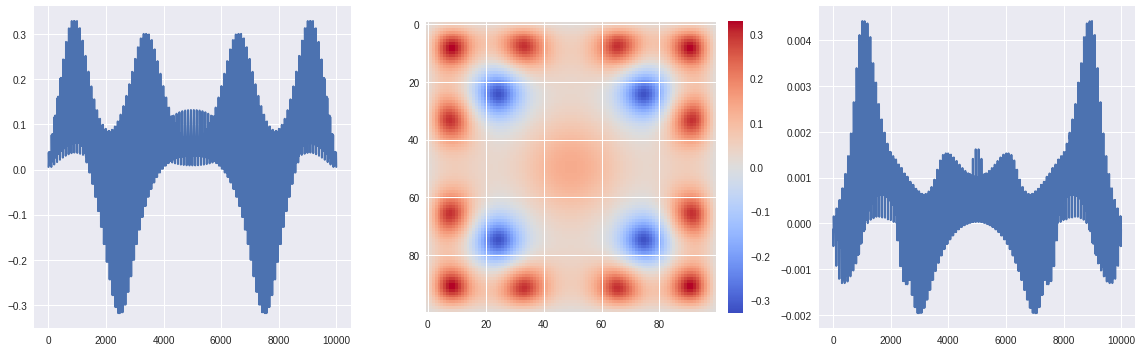

In [ ]:
plt.figure(figsize=(16, 5))
plt.subplot(132)
plt.imshow(res_1.x.reshape((n, n)), cmap='coolwarm', vmin=-max(abs(res_1.x)), vmax=max(abs(res_1.x)))
plt.colorbar(use_gridspec = True, fraction=0.046, pad=0.04)
plt.subplot(131)
plt.plot(res_1.x)
plt.subplot(133)
plt.plot(res_1.fun)
plt.tight_layout()

In [ ]:
res_2 = least_squares(fun, u0, jac=jac, bounds=(0, np.inf), gtol=1e-3,
                      args=(n, f, f_prime, c), kwargs={'jac_rows': jac_rows, 'jac_cols': jac_cols}, verbose=1)

`gtol` termination condition is satisfied.
Function evaluations 34, initial cost 1.0412e+02, final cost 4.0941e-02, first-order optimality 9.96e-04.


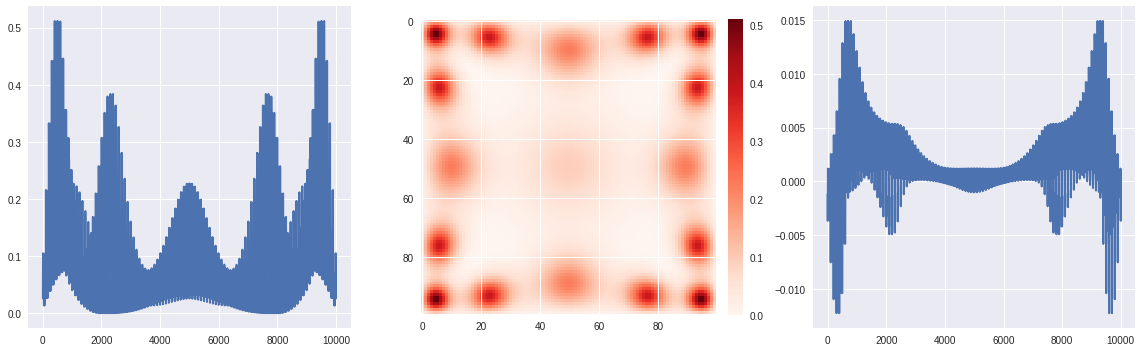

In [ ]:
plt.figure(figsize=(16, 5))
plt.subplot(132)
plt.imshow(res_2.x.reshape((n, n)), cmap='Reds')
plt.colorbar(use_gridspec=True, fraction=0.046, pad=0.04)
plt.subplot(131)
plt.plot(res_2.x)
plt.subplot(133)
plt.plot(res_2.fun)
plt.tight_layout()

sparse solver time: 0.00045899999999932106
linalg solver time: 0.0009820000000004825


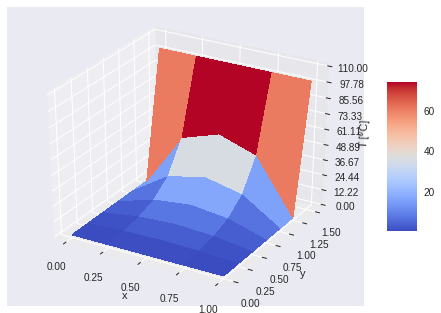

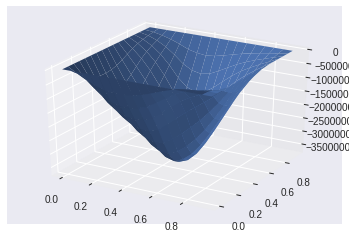

In [ ]:
"""In module are realised methods for solving Poisson's equation.
1) Jacobi method
2) Gauss–Seidel method
3) Multigrid method
"""
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def showPlot(inputArray, size_grid):
    size_grid += 1
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(0, 1, 1 / size_grid)
    y = np.arange(0, 1, 1 / size_grid)
    xgrid, ygrid = np.meshgrid(x, y)
    ax.plot_surface(xgrid, ygrid, inputArray, rstride=1, cstride=1)
    plt.show()


def function_for_test_1(x, y):
    """
    Right part of test task as function
    :param x: variable x in function
    :param y: variable y in function
    :return: calculated value of function
    """
    return -6 * (pow(x, 2) * y * (pow(x, 2) + 2 * pow(y, 2)))


def function_for_test_2():
    pass


def set_right_part_of_equation(n):
    """
    Method set right part of equation for every point in grid
    :param n: number of steps
    :return: matrix filled with right parts of grid
    """
    n +=1
    #  m: y coordinate
    #  k: x coordinate
    matrix_F = np.zeros((n, n))  # matrix of right parts of grid
    for m in range(n):
        for k in range(n):
            matrix_F[k][m] = function_for_test_1(k / n, m / n)
    return matrix_F


def set_boundary_conditions(n, h):
    """
    Method sets the boundary conditions
    :param n: number of steps
    :param h: step of iteration
    :return: matrix filled with boundary conditions
    """
    n += 1
    matrix = np.zeros((n, n))  # Set matrix of boundary conditions
    #  m: y coordinate
    #  k: x coordinate
    for m in range(n):
        matrix[n - 1][m] = pow((n * h), 4) * pow((m * h), 3)
    for k in range(n):
        matrix[k][n - 1] = pow((k * h), 4) * pow((n * h), 3)
    return np.array(matrix)


def calculation_of_residual(n, last_arr, f, h):
    n += 1
    r = np.zeros((n, n))
    for m in range(1, n - 1):
        for k in range(1, n - 1):
            r[k][m] = -f[k][m] - ((last_arr[k + 1][m] - 2 * last_arr[k][m] + last_arr[k - 1][m]) / h ** 2 + (
                last_arr[k][m + 1] - 2 * last_arr[k][m] + last_arr[k][m - 1]) / h ** 2)
    return r


def double_differention(n, arr, h):
    n += 1
    r = np.zeros((n, n))
    for m in range(1, n - 1):
        for k in range(1, n - 1):
            r[k][m] = (arr[k + 1][m] - 2 * arr[k][m] + arr[k - 1][m]) / h ** 2 + (
                arr[k][m + 1] - 2 * arr[k][m] + arr[k][m - 1]) / h ** 2
    return r


def jacobi_method_solving(n, eps, max_iter):
    """
    Jacobi method
    :param n: number of grid points along x (as number of nodes on y)
    :param eps: accuracy
    :param max_iter: maximum number of iterations
    """
    h = 1 / n  # Step of iteration

    #  Stage 1: set boundary conditions
    last_arr = set_boundary_conditions(n, h).copy()
    now_arr = set_boundary_conditions(n, h).copy()

    #  Stage 2: set right part of equation
    f = set_right_part_of_equation(n).copy()

    # Stage 3: Start iterate
    i = 0
    resold = 0
    while max_iter > i:
        i += 1
        for m in range(1, n - 1):
            for k in range(1, n - 1):
                now_arr[k][m] = 1 / 4 * (last_arr[k + 1][m] + last_arr[k - 1][m] + last_arr[k][m - 1] +
                                         last_arr[k][m + 1] + h ** 2 * f[k][m])

        r = np.max(abs(calculation_of_residual(n, now_arr, f, h)))
        last_arr = now_arr.copy()
        if i == 1:
            resold = r
        if r / resold < eps:
            i = max_iter
    showPlot(now_arr, n)


def gauss_seidel_method_solving(n, eps, max_iter, f, now_arr):
    """
    Gauss-Seidel method
    :param n: number of grid points along x (as number of nodes on y)
    :param eps: accuracy
    :param max_iter: maximum number of iterations
    """
    h = 1 / n  # Step of iteration

    # Stage 3: Start iterate
    i = 0
    resold = 0
    iterations_count = 0

    while max_iter > i:
        i += 1

        for m in range(1, n):
            for k in range(1, n):
                now_arr[k][m] = 1 / 4 * (now_arr[k + 1][m] + now_arr[k - 1][m] + now_arr[k][m - 1] +
                                         now_arr[k][m + 1] + h ** 2 * f[k][m])

        r = np.max(abs(calculation_of_residual(n, now_arr, f, h)))
        if np.max(r) < eps or i > 100:
            iterations_count = i
            i = max_iter
    return now_arr, iterations_count


def conversion_to_rough_grid(input_array, prev_size_grid):
    """
    The operator switch to a rough grid
    :param input_array: Initial matrix
    :param prev_size_grid: Initial grid size
    :return: New matrix and new matrix size
    """
    new_size_grid = prev_size_grid // 2
    out_array = np.zeros((new_size_grid + 1, new_size_grid + 1))
    for i in range(new_size_grid + 1):
        for j in range(new_size_grid + 1):
            out_array[i][j] = input_array[i * 2][j * 2]
    return out_array, new_size_grid


def conversion_to_detailed_grid(input_array, prev_size_grid):
    """
    The operator switch to a detailed grid
    :param input_array: Initial matrix
    :param prev_size_grid: Initial grid size
    :return: New matrix and new matrix size
    """
    new_size_grid = prev_size_grid * 2
    out_array = np.zeros((new_size_grid + 1, new_size_grid + 1))
    i_parity = False  # oddness i
    j_parity = False  # oddness j
    for i in range(new_size_grid + 1):
        for j in range(new_size_grid + 1):
            i_parity = i % 2 == 0
            j_parity = j % 2 == 0
            if i_parity and j_parity:
                out_array[i][j] = input_array[i // 2][j // 2]
            elif not i_parity and j_parity:
                out_array[i][j] = 0.5 * (input_array[i // 2][j // 2] + input_array[(i + 2) // 2][j // 2])
            elif i_parity and not j_parity:
                out_array[i][j] = 0.5 * (input_array[i // 2][j // 2] + input_array[i // 2][(j + 2) // 2])
            else:
                out_array[i][j] = 0.25 * (
                    input_array[i // 2][j // 2] + input_array[i // 2][(j + 2) // 2] + input_array[(i + 2) // 2][
                        j // 2] +
                    input_array[(i + 2) // 2][(j + 2) // 2])
    return out_array, new_size_grid


def multigrid_method_solving(n, eps, max_iter):
    h = 1 / n  # Step of iteration
    max_iter_for_zeidel = 1

    # Cicle of V cycles
    iter = 0
    resold = 0

    deep_v_cycle = int(np.math.log(n, 2))

    grid_size = n

    now_arr = set_boundary_conditions(n, h).copy()

    f = set_right_part_of_equation(n).copy()

    while iter < max_iter:
        iter += 1
        now_arr = gauss_seidel_method_solving(n, 0.1, max_iter_for_zeidel, f, now_arr)[0]

        r = calculation_of_residual(n, now_arr, f, h)
        grid_size = n
        r_arr = []
        mu_arr = []

        for i in range(deep_v_cycle - 1):
            r, grid_size = conversion_to_rough_grid(r, grid_size)

            mu = gauss_seidel_method_solving(grid_size, 0.1, max_iter_for_zeidel, r,
                                                    np.zeros((grid_size+1,grid_size+1)))[0]
            mu_arr.append(mu)  # Save residual of this stage
            double_diff_mu = double_differention(grid_size, mu, h)
            r = r - double_diff_mu
            r_arr.append(r)
#             showPlot(r, grid_size)

        mu, grid_size = conversion_to_detailed_grid(mu_arr[-1], grid_size)
        mu_star = mu_arr[-2] + mu
        new_mu = gauss_seidel_method_solving(grid_size, 0.1, max_iter_for_zeidel, r_arr[-2], mu_star)[0]
        for i in range(3, len(mu_arr)+1):
            mu, grid_size = conversion_to_detailed_grid(new_mu, grid_size)
            mu_star = mu_arr[-i] + mu
            new_mu = gauss_seidel_method_solving(grid_size, 0.1, max_iter_for_zeidel, r_arr[-i], mu_star)[0]
        mu, grid_size = conversion_to_detailed_grid(new_mu, grid_size)
        u_star = now_arr + mu
        now_arr = gauss_seidel_method_solving(n, 0.1, max_iter_for_zeidel, f, u_star)[0]

    showPlot(now_arr, n)


if __name__ == "__main__":
    n = 16
    h = 1 / n

#     jacobi_method_solving(32, 0.1, 10000)
    gauss_seidel_method_solving(n, 0.01, 10000, set_right_part_of_equation(n + 1).copy(), set_boundary_conditions(n + 1, h).copy())
    multigrid_method_solving(n, 0.01, 5)

In [ ]:
from scipy import sparse

def make_A(k):
    """Create the matrix for the problem on a k-by-k grid.
    Parameters: 
      k: number of grid points in each dimension.
    Outputs:
      A: the sparse k**2-by-k**2 matrix representing the finite difference approximation to Poisson's equation.
    """
    # First make a list with one triple (row, column, value) for each nonzero element of A
    triples = []
    for i in range(k):
        for j in range(k):
            # what row of the matrix is grid point (i,j)?
            row = j + i * k
            # the diagonal element in this row
            triples.append((row, row, 4.0))
            # connect to left grid neighbor
            if j > 0:
                triples.append((row, row - 1, -1.0))
            # ... right neighbor
            if j < k - 1:
                triples.append((row, row + 1, -1.0))
            # ... neighbor above
            if i > 0:
                triples.append((row, row - k, -1.0))
            # ... neighbor below
            if i < k - 1:
                triples.append((row, row + k, -1.0))
    
    # Finally convert the list of triples to a scipy sparse matrix
    ndim = k * k
    rownum = [t[0] for t in triples]
    colnum = [t[1] for t in triples]
    values = [t[2] for t in triples]

    A = sparse.csr_matrix((values, (rownum, colnum)), shape = (ndim, ndim))
    
    
    return A


def make_b(k, top = 0, bottom = 0, left = 0, right = 0):
    """Create the right-hand side for the problem on a k-by-k grid.
    Parameters: 
      k: number of grid points in each dimension.
      top: list of k values for top boundary (optional, defaults to 0)
      bottom: list of k values for bottom boundary (optional, defaults to 0)
      left: list of k values for top boundary (optional, defaults to 0)
      right: list of k values for top boundary (optional, defaults to 0)
    Outputs:
      b: the k**2 element vector (as a numpy array) for the rhs of the Poisson equation with given boundary conditions
    """
    # Start with a vector of zeros
    ndim = k * k
    b = np.zeros(shape = ndim)
    
    # Fill in the four boundaries as appropriate
    b[0        : k       ] += top
    b[ndim - k : ndim    ] += bottom
    b[0        : ndim : k] += left
    b[k-1      : ndim : k] += right
    
    return b

In [ ]:
A = make_A(7).todense()

In [ ]:
for i, row in enumerate(A):
  print(row)
  if i >= 0: break

[[ 4. -1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [ ]:
b = make_b(7)